#  AT&T Spam Detector


# Executive Summary 

* Point 1

# TODO & Ideas - TO BE COMMENTED

* ~~Spend time to analyze the results of the basic model~~
* Add explanation about the number of parameters of the basic model
* Mostly based on : ``07_deep_learning\08_Word_Embedding\04-Embedding_for_sentiment_analysis.ipynb``
* I highly recommend to create a virtual environnement named``att`` (python 3.10 is important for TF)

```
conda create --name att python=3.10
conda activate att
code .
# VSCode will ask to install ipykernel

# Open a terminal in VScode, double check att is current envinment then
conda install tensorflow
conda install spacy
conda install pandas
conda install wordcloud
conda install scikit-learn 
conda install plotly
conda install nbformat
python -m spacy download en_core_web_sm

# Final step
pip freeze > ./assets/requirements.txt

```

Once in another brand new environment (<span style="color:red"><b>NOT</b></span> tested yet)
```
conda install --yes --file requirements.txt
```


# Summary of the specs

* https://app.jedha.co/course/projects-deep-learning-ft/att-spam-detector-ft

## Goals
* Your goal is to build a spam detector, that can automatically flag spams as they come based solely on the sms" content.

## Start simple
* A good <span style="color:orange"><b>deep learing model</b></span> does not necessarily have to be super complicated!

## Transfer learning
* You do not have access to a whole lot of data, perhaps channeling the power of a more sophisticated model trained on billions of observations might help!



# EDA

In [71]:
# prelude

import re
# import spacy
import pandas as pd
import numpy as np

import en_core_web_sm
import tensorflow as tf
# import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# from tensorflow.keras import Sequential
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.model_selection import train_test_split
# from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D


from pathlib import Path
# k_CurrentDir  = Path(__file__).parent    # __file__ is not known in Jupyter context
k_Current_dir   = Path.cwd()
k_AssetsDir     = "assets"
k_Gold          = 1.618                    # gold number for ratio
k_Width         = 12
k_Height        = k_Width/k_Gold
k_WidthPx       = 1024
k_HeightPx      = k_WidthPx/k_Gold
k_random_state  = 42
k_test_size     = 0.3
k_epochs        = 100                      # I tried 10, 20 and 50

In [72]:
# -----------------------------------------------------------------------------
def quick_View(df: pd.DataFrame) -> pd.DataFrame:

    """
    Generates a summary DataFrame for each column in the input DataFrame.

    This function analyzes each column in the given DataFrame and creates a summary that includes
    data type, number of null values, percentage of null values, number of non-null values, 
    number of distinct values, min and max values, outlier bounds (for numeric columns),
    and the frequency of distinct values.

    Args:
        df (pd.DataFrame): The input DataFrame to analyze.

    Returns:
        pd.DataFrame: A DataFrame containing the summary of each column from the input DataFrame. 
                      Each row in the resulting DataFrame represents a column from the input DataFrame
                      with the following information:
                      - "name": Column name
                      - "dtype": Data type of the column
                      - "# null": Number of null values
                      - "% null": Percentage of null values
                      - "# NOT null": Number of non-null values
                      - "distinct val": Number of distinct values
                      - "-3*sig": Lower bound for outliers (mean - 3*std) for numeric columns
                      - "min": Minimum value for numeric columns
                      - "max": Maximum value for numeric columns
                      - "+3*sig": Upper bound for outliers (mean + 3*std) for numeric columns
                      - "distinct val count": Dictionary of distinct value counts or top 10 values for object columns
    """

    summary_lst = []
  
    for col_name in df.columns:
        col_dtype               = df[col_name].dtype
        num_of_null             = df[col_name].isnull().sum()
        percent_of_null         = num_of_null/len(df)
        num_of_non_null         = df[col_name].notnull().sum()
        num_of_distinct_values  = df[col_name].nunique()

        if num_of_distinct_values <= 10:
            distinct_values_counts = df[col_name].value_counts().to_dict()
        else:
            top_10_values_counts    = df[col_name].value_counts().head(10).to_dict()
            distinct_values_counts  = {k: v for k, v in sorted(top_10_values_counts.items(), key=lambda item: item[1], reverse=True)}

        if col_dtype != "object":
            max_of_col = df[col_name].max()
            min_of_col = df[col_name].min()
            outlier_hi = df[col_name].mean() + 3*df[col_name].std()
            outlier_lo = df[col_name].mean() - 3*df[col_name].std()
        else:
            max_of_col = -1
            min_of_col =  1
            outlier_hi = -1
            outlier_lo =  1

        summary_lst.append({
            "name"                : col_name,
            "dtype"               : col_dtype,
            "# null"              : num_of_null,
            "% null"              : (100*percent_of_null).round(2),
            "# NOT null"          : num_of_non_null,
            "distinct val"        : num_of_distinct_values,
            "-3*sig"              : round(outlier_lo,2) ,
            "min"                 : round(min_of_col,2),
            "max"                 : round(max_of_col,2),
            "+3*sig"              : round(outlier_hi,2) ,
            "distinct val count"  : distinct_values_counts
        })

    df_tmp = pd.DataFrame(summary_lst)
    return df_tmp

In [73]:
# -----------------------------------------------------------------------------
# drop empty cols and duplicates, rename cols...
def cleaner(df):
    df.drop(columns="Unnamed: 2", inplace=True)
    df.drop(columns="Unnamed: 3", inplace=True)
    df.drop(columns="Unnamed: 4", inplace=True)

    df.drop_duplicates(inplace=True)

    df.columns = df.columns.str.lower()
    df.columns = df.columns.str.replace("/", "_")

    df.rename(columns={"v1": "target"}, inplace=True)
    df.rename(columns={"v2": "text"}, inplace=True)

    return df

In [74]:
# df = pd.read_csv("https://full-stack-bigdata-datasets.s3.eu-west-3.amazonaws.com/Deep+Learning/project/spam.csv", encoding="cp1252")
df = pd.read_csv(k_Current_dir / k_AssetsDir / "spam.csv", encoding="cp1252")

print(f"\n\nPreview of the dataset (raw) :")
display(df.head())

df = cleaner(df)
print(f"\n\nPreview of the initial dataset :")
display(df.head())

print(f"\n\nThe dataset consists of :")
print(f"\t{len(df.shape):>9_} dimensions")
print(f"\t{df.shape[0]:>9_} observations")
print(f"\t{df.shape[1]:>9_} features    ")

print(f"\n\nIt's a binary classification problem")

df_types = pd.DataFrame ({
  "types" : df.dtypes.value_counts()
})
df_types["as_%"] = (100 * df_types["types"]/df_types["types"].sum()).round(2)

print(f"\n\n% of data type :")
display(df_types)

df_tmp = quick_View(df)
print(f"\n\nQuickView :")
display(df_tmp.sort_values(by="# null", ascending=False))   

print(f"\n\n% of missing values :")
display(round(df.isnull().sum()/len(df)*100, 2))



Preview of the dataset (raw) :


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN




Preview of the initial dataset :


,target,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."




The dataset consists of :
	        2 dimensions
	    5_169 observations
	        2 features    


It's a binary classification problem


% of data type :


,types,as_%
object,2,100.0




QuickView :


,name,dtype,# null,% null,# NOT null,distinct val,-3*sig,min,max,+3*sig,distinct val count
0,target,object,0,0.0,5169,2,1,1,-1,-1,"{'ham': 4516, 'spam': 653}"
1,text,object,0,0.0,5169,5169,1,1,-1,-1,"{'Go until jurong point, crazy.. Available onl..."




% of missing values :


target    0.0
text      0.0
dtype: float64

## <span style="color:orange"><b>Comments :</b></span>
* There is no missing values
* 5k observations. Will it be enough ?
* Unbalanced target

## Spam & ham balance

Nb spam :     653
Nb ham  :   4_516


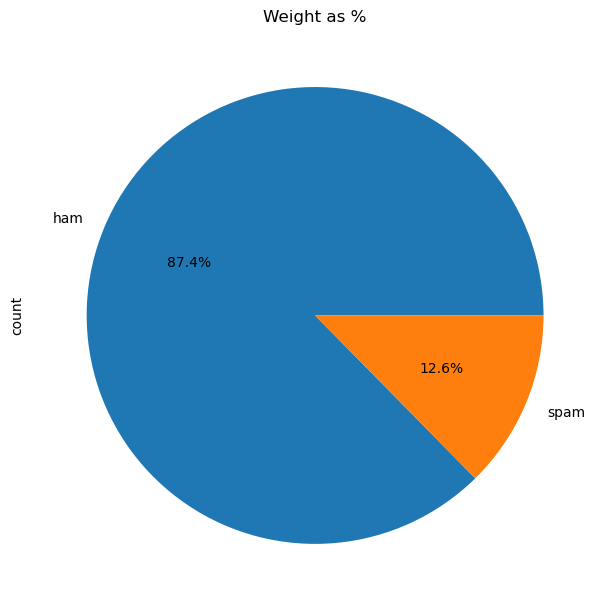

In [75]:
counts = df["target"].value_counts()
print(f"Nb spam : {counts['spam']:>7_}")
print(f"Nb ham  : {counts['ham']:>7_}")

_ = counts.plot.pie(title="Weight as %", autopct="%1.1f%%", figsize=(k_Width, k_Height))

### <span style="color:orange"><b>Comments :</b></span>
* No surprise, the target is heavily unbalanced

# Text processing


## How ham and spam text look like ?

In [76]:
print(f"\n\nHAM : ")
# pd.set_option("display.max_colwidth", 1000)
# print(df[df["target"]=="ham"].head(20))
print(df[df["target"]=="ham"].head(20).to_string())



HAM : 
   target                                                                                                                                                                                                  text
0     ham                                                                                       Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
1     ham                                                                                                                                                                         Ok lar... Joking wif u oni...
3     ham                                                                                                                                                     U dun say so early hor... U c already then say...
4     ham                                                                                                                                         Nah I don't t

In [77]:
print(f"\n\nSPAM : ")

print(df[df["target"]=="spam"].head(20).to_string())



SPAM : 
    target                                                                                                                                                                          text
2     spam                   Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
5     spam                          FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, å£1.50 to rcv
8     spam                WINNER!! As a valued network customer you have been selected to receivea å£900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.
9     spam                    Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free! Call The Mobile Update Co FREE on 08002986030
11    spam                                      SIX chances to wi

## Cleaning

In [78]:
# The 2 lines below can help to print the punctuation signs
# import string 
# string.punctuation

# Remove punctuation  
df["clean_docs"] = df["text"].apply(lambda x: re.sub("[!\"#$%&()*+,-./:;<=>?@\[\]^_`{|}~\\\]+"," ", x)) 

# fillna() makes sure NA is replaced with "" so that lowering case do not generate error
df["clean_docs"] = df["clean_docs"].fillna("").apply(lambda x: x.lower())

# df["clean_docs"].head(20)
df


,target,text,clean_docs
0,ham,"Go until jurong point, crazy.. Available only ...",go until jurong point crazy available only i...
1,ham,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in 2 a wkly comp to win fa cup fina...
3,ham,U dun say so early hor... U c already then say...,u dun say so early hor u c already then say
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah i don't think he goes to usf he lives aro...
...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,this is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?,will ì b going to esplanade fr home
5569,ham,"Pity, * was in mood for that. So...any other s...",pity was in mood for that so any other sug...
5570,ham,The guy did some bitching but I acted like i'd...,the guy did some bitching but i acted like i'd...


## Tokenization

In [79]:
nlp = en_core_web_sm.load()

# Tokenize the cleaned document
df["tokenized_docs"] = df["clean_docs"].fillna("").apply(lambda x: nlp(x))

# remove stop-words, replace words with their lemma
df["tokenized_docs"] = df["tokenized_docs"].apply(lambda x: [token.lemma_ for token in x if token.text not in STOP_WORDS])
# df["tokenized_docs"].head(20)

# clean up tokenized documents
df["clean_tokens"] = [" ".join(x) for x in df["tokenized_docs"]]

# set the target as boolean value (spam=1) 
df["target"] = df["target"].map({"ham":0,"spam":1})
df


,target,text,clean_docs,tokenized_docs,clean_tokens
0,0,"Go until jurong point, crazy.. Available only ...",go until jurong point crazy available only i...,"[jurong, point, , crazy, , available, bugis,...",jurong point crazy available bugis n great...
1,0,Ok lar... Joking wif u oni...,ok lar joking wif u oni,"[ok, lar, , joke, wif, u, oni]",ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in 2 a wkly comp to win fa cup fina...,"[free, entry, 2, wkly, comp, win, fa, cup, fin...",free entry 2 wkly comp win fa cup final tkts 2...
3,0,U dun say so early hor... U c already then say...,u dun say so early hor u c already then say,"[u, dun, early, hor, , u, c]",u dun early hor u c
4,0,"Nah I don't think he goes to usf, he lives aro...",nah i don't think he goes to usf he lives aro...,"[nah, think, go, usf, , live]",nah think go usf live
...,...,...,...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...,this is the 2nd time we have tried 2 contact u...,"[2nd, time, try, 2, contact, u, , u, win, å£7...",2nd time try 2 contact u u win å£750 pound p...
5568,0,Will Ì_ b going to esplanade fr home?,will ì b going to esplanade fr home,"[ì, , b, go, esplanade, fr, home]",ì b go esplanade fr home
5569,0,"Pity, * was in mood for that. So...any other s...",pity was in mood for that so any other sug...,"[pity, , mood, , suggestion]",pity mood suggestion
5570,0,The guy did some bitching but I acted like i'd...,the guy did some bitching but i acted like i'd...,"[guy, bitching, act, like, interested, buy, we...",guy bitching act like interested buy week give...


## Word Cloud

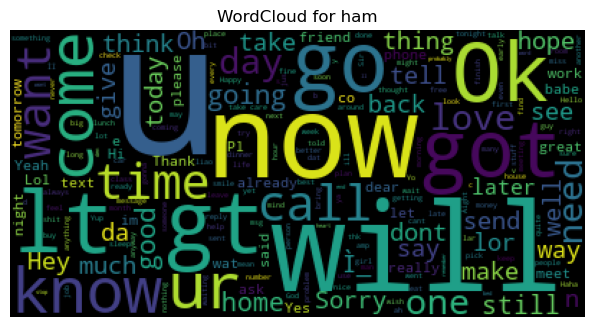

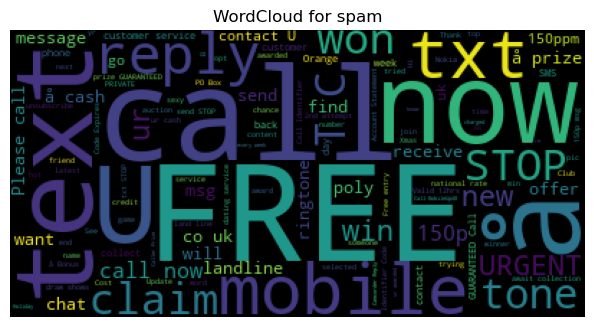

In [97]:
for i in set(df["target"]):
    words = ""
    for doc in df[df["target"] == i]["text"]:
        words += doc + " "
    wordcloud = WordCloud().generate(words)
    plt.figure(figsize = (k_Height, k_Width))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(f"WordCloud for {'spam' if i==1 else 'ham'}")
    plt.show()

### <span style="color:orange"><b>Comments :</b></span>

* With no surprise "free", "call", "now"... are dominant in spams sms
* Surprisingly "sex" and "viagra" are missing 😁

## Word occurence

In [81]:
# SPAM
df_tmp = " ".join(df[df["target"] == 1]["clean_tokens"])
df_tmp = pd.DataFrame(df_tmp.split(" "))
df_tmp = df_tmp.value_counts(ascending=False)

df_tmp = df_tmp.reset_index()  
df_tmp.columns = ["word", "occurrences"]  
df_tmp.set_index("word", inplace=True)  
df_tmp


,occurrence
word,
,4422
free,195
2,171
txt,142
u,141
...,...
complete,1
complementary,1
compensation,1


In [82]:
# HAM
df_tmp = " ".join(df[df["target"] == 0]["clean_tokens"])
df_tmp = pd.DataFrame(df_tmp.split(" "))
df_tmp = df_tmp.value_counts(ascending=False)

df_tmp = df_tmp.reset_index()  
df_tmp.columns = ["word", "occurrences"]  
df_tmp.set_index("word", inplace=True)  
df_tmp


,occurrence
word,
,15231
u,902
go,310
2,302
come,299
...,...
breath,1
breakin,1
breakfast,1


## Tokenization

In [83]:
# instanciate the tokenizer , oov_token="out_of_vocab"
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=1000, oov_token="_UNKNOWN_") 
tokenizer.fit_on_texts(df["clean_tokens"])
df["sms_encoded"] = tokenizer.texts_to_sequences(df["clean_tokens"])
df


,target,text,clean_docs,tokenized_docs,clean_tokens,sms_encoded
0,0,"Go until jurong point, crazy.. Available only ...",go until jurong point crazy available only i...,"[jurong, point, , crazy, , available, bugis,...",jurong point crazy available bugis n great...,"[1, 253, 445, 468, 921, 37, 60, 272, 922, 75, ..."
1,0,Ok lar... Joking wif u oni...,ok lar joking wif u oni,"[ok, lar, , joke, wif, u, oni]",ok lar joke wif u oni,"[14, 207, 495, 301, 2, 1]"
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in 2 a wkly comp to win fa cup fina...,"[free, entry, 2, wkly, comp, win, fa, cup, fin...",free entry 2 wkly comp win fa cup final tkts 2...,"[15, 372, 3, 762, 715, 46, 1, 1, 496, 1, 1, 1,..."
3,0,U dun say so early hor... U c already then say...,u dun say so early hor u c already then say,"[u, dun, early, hor, , u, c]",u dun early hor u c,"[2, 129, 154, 1, 2, 56]"
4,0,"Nah I don't think he goes to usf, he lives aro...",nah i don't think he goes to usf he lives aro...,"[nah, think, go, usf, , live]",nah think go usf live,"[716, 24, 5, 659, 175]"
...,...,...,...,...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...,this is the 2nd time we have tried 2 contact u...,"[2nd, time, try, 2, contact, u, , u, win, å£7...",2nd time try 2 contact u u win å£750 pound p...,"[309, 19, 57, 3, 106, 2, 2, 46, 1, 334, 84, 3,..."
5568,0,Will Ì_ b going to esplanade fr home?,will ì b going to esplanade fr home,"[ì, , b, go, esplanade, fr, home]",ì b go esplanade fr home,"[45, 97, 5, 1, 581, 28]"
5569,0,"Pity, * was in mood for that. So...any other s...",pity was in mood for that so any other sug...,"[pity, , mood, , suggestion]",pity mood suggestion,"[1, 1, 1]"
5570,0,The guy did some bitching but I acted like i'd...,the guy did some bitching but i acted like i'd...,"[guy, bitching, act, like, interested, buy, we...",guy bitching act like interested buy week give...,"[121, 1, 1, 16, 979, 93, 44, 326, 15]"


## Padding

In [84]:
# Tensorflow cannot create a tensor dataset based on lists
# We have to store encoded sms into a numpy array before creating the tensorflow dataset
# However, not all the sequences are the same length
# This is where `tf.keras.preprocessing.sequence.pad_sequences()` comes in 
# It will add zero padding at the beginning (`padding="pre"`) or at the end (`padding="post"`) of your sequences so they all have equal length
sms_padded = tf.keras.preprocessing.sequence.pad_sequences(df["sms_encoded"], padding="post")
print(sms_padded)
print(sms_padded.shape)

[[  1 253 445 ...   0   0   0]
 [ 14 207 495 ...   0   0   0]
 [ 15 372   3 ...   0   0   0]
 ...
 [  1   1   1 ...   0   0   0]
 [121   1   1 ...   0   0   0]
 [  1 367   0 ...   0   0   0]]
(5169, 77)


## Split

In [85]:
# stratify
X_train, X_test, y_train, y_test = train_test_split(sms_padded, df["target"], test_size = k_test_size, random_state = k_random_state, stratify = df["target"])

## Create Tensor

In [86]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [87]:
# Make sure that data are blended/mixed and divided into batches of 64 observations for training
train_batch = train_ds.shuffle(len(train_ds)).batch(64)
test_batch = test_ds.shuffle(len(test_ds)).batch(64)

for sms, ham_spam in train_batch.take(1):
  print(sms, ham_spam)

print(sms.shape)

tf.Tensor(
[[107 131   8 ...   0   0   0]
 [527  66 157 ...   0   0   0]
 [ 71  39 105 ...   0   0   0]
 ...
 [  1   1  60 ...   0   0   0]
 [  2  24 167 ...   0   0   0]
 [318   2   3 ...   0   0   0]], shape=(64, 77), dtype=int32) tf.Tensor(
[0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0
 0 1 1 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0], shape=(64,), dtype=int64)
(64, 77)


# Modeling


In [88]:
vocab_size = tokenizer.num_words
model = tf.keras.Sequential([
    # Input Word Embedding
    tf.keras.layers.Embedding(vocab_size+1, 8, input_shape=[sms.shape[1],], name="embedding"),

    # Gobal average pooling
    tf.keras.layers.GlobalAveragePooling1D(),

    # Dense
    tf.keras.layers.Dense(16, activation="relu"),

    # Couche de sortie avec le nombre de neurones en sortie égale au nombre de classes 
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 77, 8)             8008      
                                                                 
 global_average_pooling1d_2   (None, 8)                0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_4 (Dense)             (None, 16)                144       
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 8,169
Trainable params: 8,169
Non-trainable params: 0
_________________________________________________________________


### <span style="color:orange"><b>Comments :</b></span>
* TO DO


In [89]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.Precision(name="precision"), "accuracy"]       # name=... avoid recall_1 for example
)

In [90]:
history = model.fit(
    train_batch,
    epochs = k_epochs,
    validation_data=test_batch,
)


Epoch 1/100
57/57 [==============================] - 1s 8ms/step - loss: 0.6406 - recall: 0.0197 - precision: 0.1698 - accuracy: 0.8640 - val_loss: 0.5746 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_accuracy: 0.8736
Epoch 2/100
57/57 [==============================] - 0s 3ms/step - loss: 0.5042 - recall: 0.0000e+00 - precision: 0.0000e+00 - accuracy: 0.8737 - val_loss: 0.4363 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_accuracy: 0.8736
Epoch 3/100
57/57 [==============================] - 0s 3ms/step - loss: 0.3897 - recall: 0.0000e+00 - precision: 0.0000e+00 - accuracy: 0.8737 - val_loss: 0.3601 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_accuracy: 0.8736
Epoch 4/100
57/57 [==============================] - 0s 3ms/step - loss: 0.3464 - recall: 0.0000e+00 - precision: 0.0000e+00 - accuracy: 0.8737 - val_loss: 0.3410 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_accuracy: 0.8736
Epoch 5/100
57/57 [==============================] -

## Evaluating

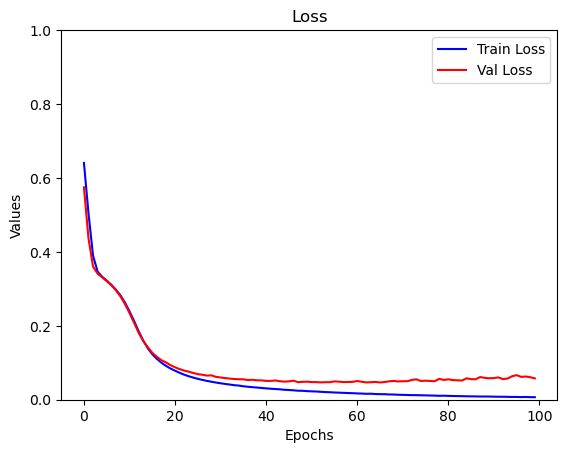

[[0.008313,
  0.008029,
  0.008043,
  0.00778,
  0.00749,
  0.007525,
  0.007181,
  0.007377,
  0.007005,
  0.006838]]

[[0.058639,
  0.060349,
  0.055809,
  0.057271,
  0.063512,
  0.066435,
  0.061787,
  0.062732,
  0.060816,
  0.057699]]

In [91]:
# "val_" stands for validation
# history.history.keys()

plt.plot(history.history["loss"], color="b", label="Train Loss")
plt.plot(history.history["val_loss"], color="r", label="Val Loss")
plt.ylabel("Values")
plt.xlabel("Epochs")
plt.title("Loss")
plt.legend()
plt.ylim(0,1)
plt.show()

# display(history.history['loss'][-10:])
display([[round(f, 6) for f in history.history['loss'][-10:]]])
display([[round(f, 6) for f in history.history['val_loss'][-10:]]])


### <span style="color:orange"><b>Comments :</b></span>
* Interpretation
    * The loss measures the error of the model on the training data
* Analysis
    * A loss of 0.063 is relatively low, indicating that the model has learned the characteristics of the data pretty well 
    * However, a low loss does not necessarily mean that the model is perfect 
    * See comments about other metrics below

### <span style="color:orange"><b>Sync point :</b></span>

<p align="center">
<img src="./assets/metrics.png" alt="drawing" width="400"/>
<p>

* Sms identified as spam (=1)
* Can I accept spam in my sms? I don't know...
* Can I accept to see an sms from my beloved CEO classified as spam? No! 
* So I want FP to tend towards 0 and precision $\frac{TP}{TP+FP}$ towards 1 (even if the recall, $\frac{TP}{TP+FN}$, is not that great )
* I decide to favour precision over recall


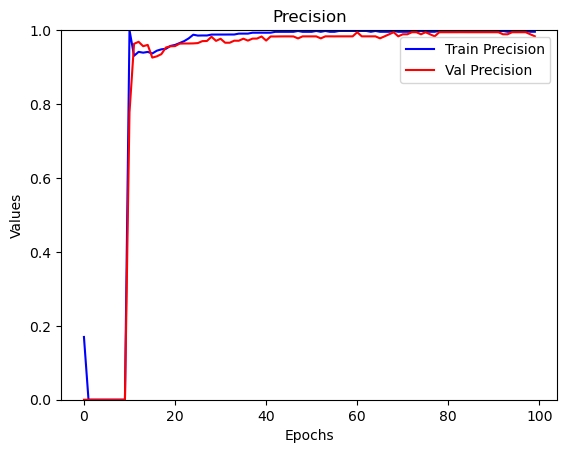

[[0.995585,
  0.995585,
  0.997783,
  0.995585,
  0.995585,
  0.995585,
  0.995595,
  0.997788,
  0.995575,
  0.995585]]

[[0.994286,
  0.994286,
  0.988764,
  0.988701,
  0.994253,
  0.99422,
  0.994286,
  0.994286,
  0.988701,
  0.98324]]

In [92]:
plt.plot(history.history["precision"], color="b", label="Train Precision")
plt.plot(history.history["val_precision"], color="r", label="Val Precision")
plt.ylabel("Values")
plt.xlabel("Epochs")
plt.title("Precision")
plt.legend()
plt.ylim(0,1)
plt.show()

display([[round(f, 6) for f in history.history['precision'][-10:]]])
display([[round(f, 6) for f in history.history['val_precision'][-10:]]])


### <span style="color:orange"><b>Comments :</b></span>
* Interpretation
    * Precision measures the proportion of true positives (sms correctly identified as spam) versus all sms classified as spam by the model (TP + FP). 
    * Right hand side column of the matrix above
    * A precision of 0.994 means that when the model predicts that an sms is spam, it is right 99.4% of the time.
* Analysis
    * Precision is excellent and this is what we want
    * The model is very effective at minimizing false positives, i.e. non-spam sms wrongly classified as spam.

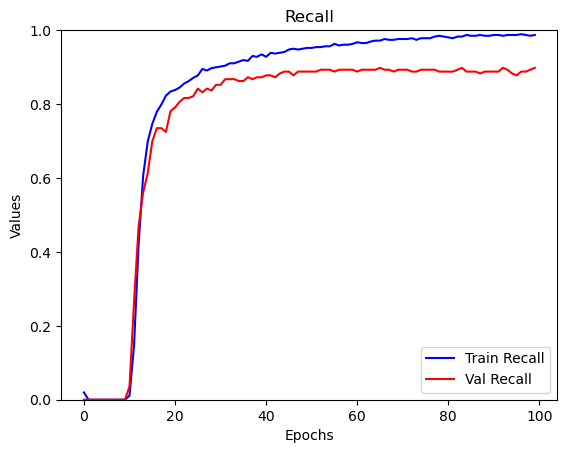

[[0.986871,
  0.986871,
  0.984683,
  0.986871,
  0.986871,
  0.986871,
  0.989059,
  0.986871,
  0.984683,
  0.986871]]

[[0.887755,
  0.887755,
  0.897959,
  0.892857,
  0.882653,
  0.877551,
  0.887755,
  0.887755,
  0.892857,
  0.897959]]

In [93]:
plt.plot(history.history["recall"], color="b", label="Train Recall")
plt.plot(history.history["val_recall"], color="r", label="Val Recall")
plt.ylabel("Values")
plt.xlabel("Epochs")
plt.title("Recall")
plt.legend()
plt.ylim(0,1)
plt.show()

display([[round(f, 6) for f in history.history['recall'][-10:]]])
display([[round(f, 6) for f in history.history['val_recall'][-10:]]])


### <span style="color:orange"><b>Comments :</b></span>


* Interpretation
    * Recall (AKA sensitivity) measures the proportion of true positives (correctly identified spam sms) to all true spam (TP + FN)
    * Bottom line of the matrix above
    * A recall of 0.892 means that the model correctly detects 89.2% of sms that are really spam
* Analysis
    * Although the recall is relatively high, it is still missing around 10.8% of spam (false negatives)

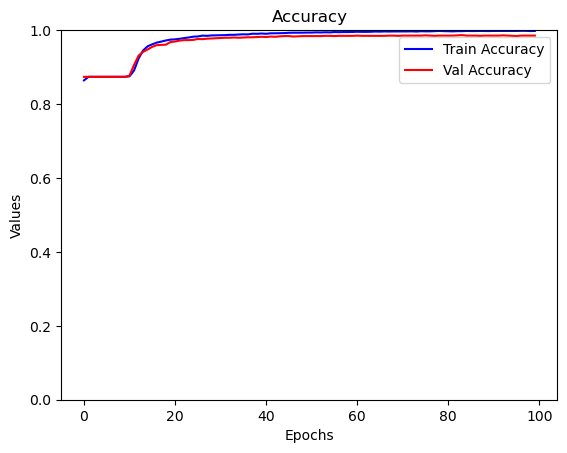

[[0.997789,
  0.997789,
  0.997789,
  0.997789,
  0.997789,
  0.997789,
  0.998065,
  0.998065,
  0.997512,
  0.997789]]

[[0.985171,
  0.985171,
  0.985816,
  0.985171,
  0.984526,
  0.983881,
  0.985171,
  0.985171,
  0.985171,
  0.985171]]

In [94]:
plt.plot(history.history["accuracy"], color="b", label="Train Accuracy")
plt.plot(history.history["val_accuracy"], color="r", label="Val Accuracy")
plt.ylabel("Values")
plt.xlabel("Epochs")
plt.title("Accuracy")
plt.legend()
plt.ylim(0,1)
plt.show()

display([[round(f, 6) for f in history.history['accuracy'][-10:]]])
display([[round(f, 6) for f in history.history['val_accuracy'][-10:]]])


### <span style="color:orange"><b>Comments :</b></span>
* Interpretation
    * Accuracy measures the total proportion of correct predictions (TP + TN) out of all predictions made (all cells of the matrix above)
    * Diagonal of the matrix
    * An accuracy of 0.985 means that the model correctly classifies 98.5% of emails
* Analysis: 
    * High accuracy is generally a good sign
    * **BUT** in a spam detection problem where the classes are unbalanced (much more non-spam than spam), high accuracy can be misleading 
    * For example, predicting that all emails are non-spam could give a good accuracy if spam is rare

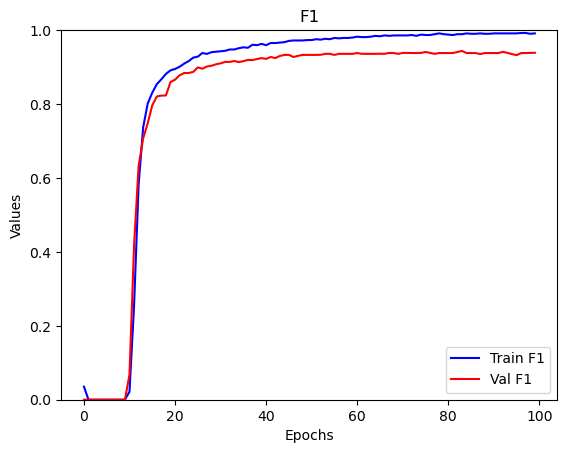

,f1
90,0.991209
91,0.991209
92,0.991189
93,0.991209
94,0.991209
95,0.991209
96,0.992316
97,0.992299
98,0.990099
99,0.991209


,val_f1
90,0.938005
91,0.938005
92,0.941176
93,0.938338
94,0.935135
95,0.932249
96,0.938005
97,0.938005
98,0.938338
99,0.938667


In [95]:
def f1_calculus(name, rec, prec):
    df_tmp=pd.DataFrame()
    df_tmp[name] = 2*np.array(rec)*np.array(prec)/(np.array(rec)+np.array(prec)+tf.keras.backend.epsilon()) # epsilon avoid runtimeWarning: divide by zero encountered in divide...
    return df_tmp

df_tmp = f1_calculus("f1", history.history["recall"], history.history["precision"])
df_val_tmp = f1_calculus("val_f1", history.history["val_recall"], history.history["val_precision"])

plt.plot(df_tmp["f1"], color="b", label="Train F1")
plt.plot(df_val_tmp["val_f1"], color="r", label="Val F1")
plt.ylabel("Values")
plt.xlabel("Epochs")
plt.title("F1")
plt.legend()
plt.ylim(0,1)
plt.show()

display(df_tmp.tail(10))
display(df_val_tmp.tail(10))




### <span style="color:orange"><b>Comments :</b></span>
* Interpretation: 
    * F1 score provides a balanced measure of the model when there's a trade-off between precision and recall 
    * It is the harmonic mean between precision and recall
    * An F1 score of 0.94 shows that the model has a good balance between precision and recall
* Analysis: 
    * The F1 score confirms that the model handles the trade-off between precision and recall pretty well
    * This is crucial in spam detection problems where false negatives (undetected spam sms) can be annoying. 
        * It is great to NOT have true sms in spam but it could be great to have no spam at all in our sms

### <span style="color:orange"><b>Conclusion (basic model evaluation) :</b></span>
* Overall, the basic model performs well and have good metrics
* However, there are a few areas for improvement
    * Recall (89% => 11%) 
    * With the others model, let's try to improve the recall without loosing to much on the precision
    * Is it possible with such small dataset ?
    * Should we consider techniques to balance the classes (SMOTE...)?
    * Should we put the model in production and collect feedback and see how it goes?

# Transfer learning

### <span style="color:orange"><b>Comments :</b></span>
* Point 1